In [33]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyedflib
import scipy.signal
import scipy.stats
import random
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
import os
import re

In [54]:
# helper function to merge two lists
def insort(a, b, kind='mergesort'):
    '''
    A function to merge two arrays and sort
    https://stackoverflow.com/questions/12427146/combine-two-arrays-and-sort
    '''
    # took mergesort as it seemed a tiny bit faster for my sorted large array try.
    c = np.concatenate((a, b)) # we still need to do this unfortunatly.
    c.sort(kind=kind)
    flag = np.ones(len(c), dtype=bool)
    np.not_equal(c[1:], c[:-1], out=flag[1:])
    return c[flag]

# check file difference
def filediff():
    pwd = os.getcwd()+'/test_edf'
    files = sorted(os.listdir(pwd))

    name_check = [s.replace('shhs1-', '') for s in files]
    name_check = [s.replace('.edf', '') for s in name_check]


    h = open('correct_files', 'r')
    file_names = h.read()
    h.close()
    file_names = file_names.splitlines()
    print(list(set(name_check) - set(file_names)))

# classify

'''
classify labels:
Normal:   0
Mild:     1
Moderate: 2
Severe:   3
'''
def dataToLabel(data):
    labels = []
    for i in data:
        if i < 5:
            labels.append(0)
        elif 5 <= i < 15:
            labels.append(1)
        elif 15 <= i < 30:
            labels.append(2)
        else:
            labels.append(3)
    return labels

In [4]:
pwd = os.getcwd()
edf_pwd = pwd + '/test_edf/'
files = sorted(os.listdir(edf_pwd))

In [5]:
final_result = {}
counter = 0
print_every = 20
for file in files:
    if file.endswith('.edf'):
        # load edf file
        g = None # initialize as None
        g = pyedflib.EdfReader(edf_pwd+file)
        n = g.signals_in_file
        signal_labels = g.getSignalLabels()
        sigbufs = [[] for n in range(n)]
        for i in np.arange(n):
            sigbufs[i] = g.readSignal(i)
        # find and extract SaO2 channel
        SaO2Idx = signal_labels.index('SaO2')
        SaO2_raw = list(sigbufs[SaO2Idx])


        # get annotation
        annotation_pwd = pwd + '/test_annotation/'
        f = open(annotation_pwd + file.replace('.edf','-nsrr.xml'), 'r')
        annotation = f.read()
        wake_pattern = re.compile(r'<EventConcept>Wake|0</EventConcept>\n<Start>(.+?)</Start>', re.DOTALL)
        wake_start_time = list(map(int, map(float, filter(None, wake_pattern.findall(annotation)))))
        wake_pattern2 = re.compile(r'<EventConcept>Wake|0</EventConcept>.+?<Duration>(.+?)</Duration>', re.DOTALL)
        wake_duration = list(map(int, map(float, filter(None, wake_pattern2.findall(annotation)))))
        wake_end_time = [x + y for x, y in zip(wake_start_time, wake_duration)]


        # get sleep time SaO2
        wake_start_time = wake_start_time[1:]
        SaO2 = []
        for i in range(len(wake_start_time)):
            SaO2 += SaO2_raw[wake_end_time[i]:wake_start_time[i]]

        SaO2 = np.asarray(SaO2)
        SaO2 = SaO2[SaO2 >= 40]

        sleep_time = len(SaO2) / 60

        # smooth data, use Savitzky–Golay filter, with window size = 17 and polyorder = 4
        window_size = 17
        polyorder = 4

        smooth_SaO2 = scipy.signal.savgol_filter(SaO2, window_size, polyorder)

        # calculate local extrema
        n = 5 #find local extrema among 6 points
        local_max = scipy.signal.argrelextrema(smooth_SaO2, np.greater, order = n)[0]
        local_min = scipy.signal.argrelextrema(smooth_SaO2, np.less, order = n)[0]

        merge_list = insort(local_max, local_min)

        '''
        a naive way to calculate SaO2 decreasement
        '''
    #     result = []
    #     for i in range(len(merge_list) - 2):
    #         if merge_list[i] in local_max and merge_list[i+1] in local_min:
    #             diff = smooth_SaO2[merge_list[i]] - smooth_SaO2[merge_list[i+1]]
    #             result.append(diff)

        '''
        Improved way to calculate decreasement
        start from maximum, suppose SaO2 is normal in the beginning
        if point i is max, and point i+1 is min, and point i+2 is max, then calcualte difference
        if point i is max, and point i+i, i+2,...,i+n are also max, calculate biggest number, i+c
        now if i+n+1 is min, i+n+2, i+n+3,...,i+n+m are also min, calculate smallest number, i+c+d
        calculate difference between SaO2[i+c+d] - SaO2[i+c], next point to start is i+n+m+1
        '''
        result = []
        i = 0
        while i < len(merge_list):
            if merge_list[i] in local_max:
                max_temp = smooth_SaO2[merge_list[i]]
                min_temp = max_temp
                max_counter = 0
                min_counter = 0
                max_location = i
                min_location = i
                # check the bound
                if i + max_counter >= len(merge_list) - 1:
                    break

                while merge_list[i + max_counter] in local_max:
                    if smooth_SaO2[merge_list[i + max_counter]] >= max_temp:
                        max_temp = smooth_SaO2[merge_list[i + max_counter]] #find the biggest number
                        max_location = i + max_counter #find the location of biggest number
                    max_counter += 1

                    #check the bound
                    if i + max_counter >= len(merge_list) - 1:
                        break
                #print('largest is', max_temp, ' Position is', merge_list[max_location])

                #calculate the min, same as max
                while i + max_counter + min_counter < len(merge_list) and merge_list[i + max_counter + min_counter] in local_min:
                    if smooth_SaO2[merge_list[i + max_counter + min_counter]] <= min_temp:
                        min_temp = smooth_SaO2[merge_list[i + max_counter + min_counter]]
                        min_location = i + max_counter + min_counter
                    min_counter += 1

                #print('smallest is', min_temp, ' Position is', merge_list[min_location])

                # calculate the diff
                diff = (max_temp - min_temp) / max_temp
                result.append(diff)

                #update pointer
                i = i + max_counter + min_counter
            else:
                i += 1


        result = np.asarray(result)
        over4 = result[result >= 0.04]
        score = (60 * len(over4)) / sleep_time
        final_result[file] = score

        counter += 1
        if counter % print_every == 0:
            print(counter, 'done.')

20 done.
40 done.
60 done.
80 done.
100 done.
120 done.
140 done.
160 done.
180 done.
200 done.
220 done.
240 done.
260 done.
280 done.
300 done.
320 done.
340 done.
360 done.
380 done.
400 done.
420 done.
440 done.
460 done.
480 done.
500 done.
520 done.
540 done.
560 done.
580 done.
600 done.
620 done.
640 done.
660 done.
680 done.
700 done.
720 done.
740 done.
760 done.
780 done.
800 done.
820 done.
840 done.


In [6]:
f = open('score', 'r')
truth = f.read()
f.close()
truth = truth.splitlines()
truth = [float(i) for i in truth]

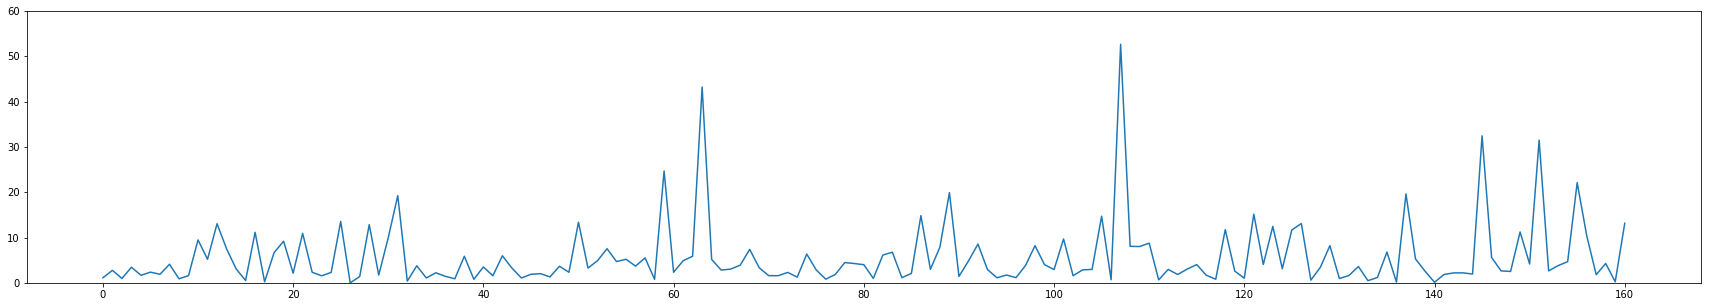

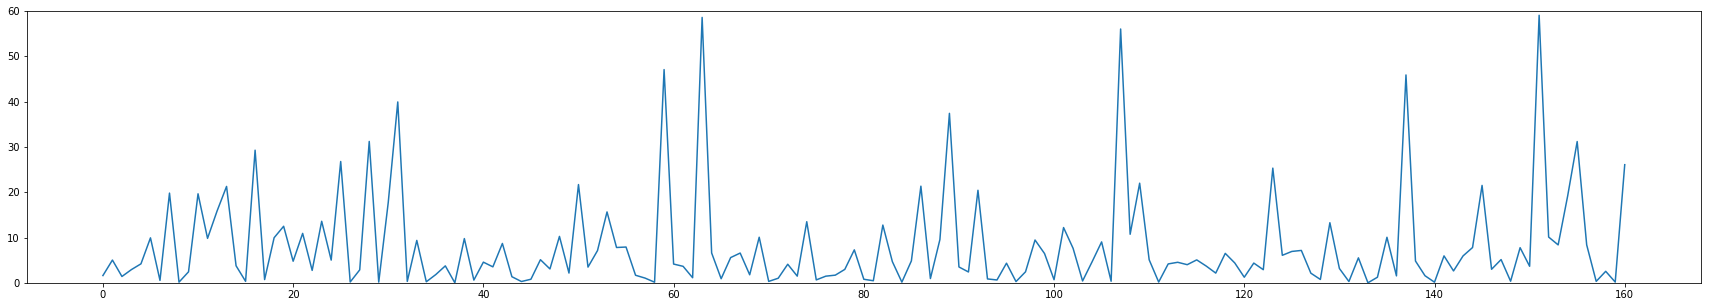

In [12]:
## result for ~200 files
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 60) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 60) 
plt.show()

In [17]:
# ~200 files
# calculate correlation, use Pearson’s Correlation
corr, _ = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)

Correlation is:  0.867735961217816


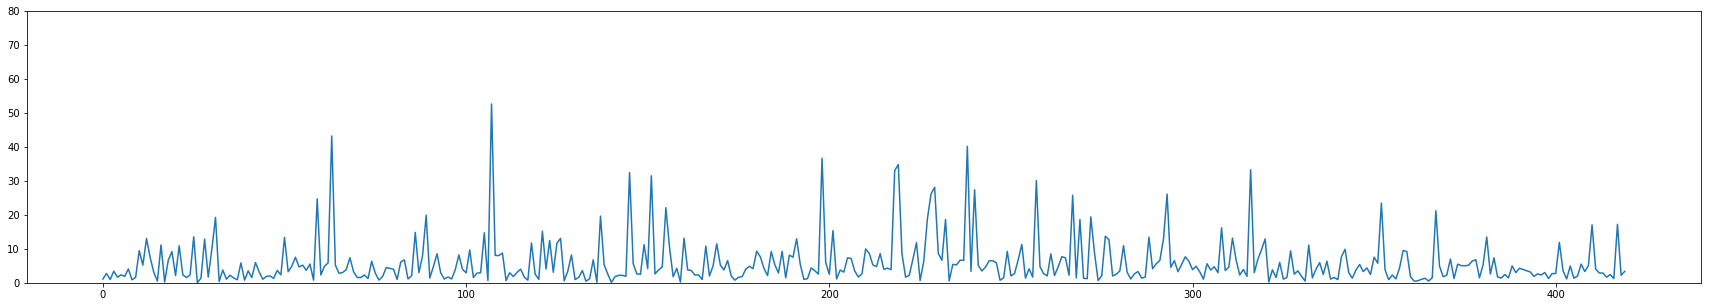

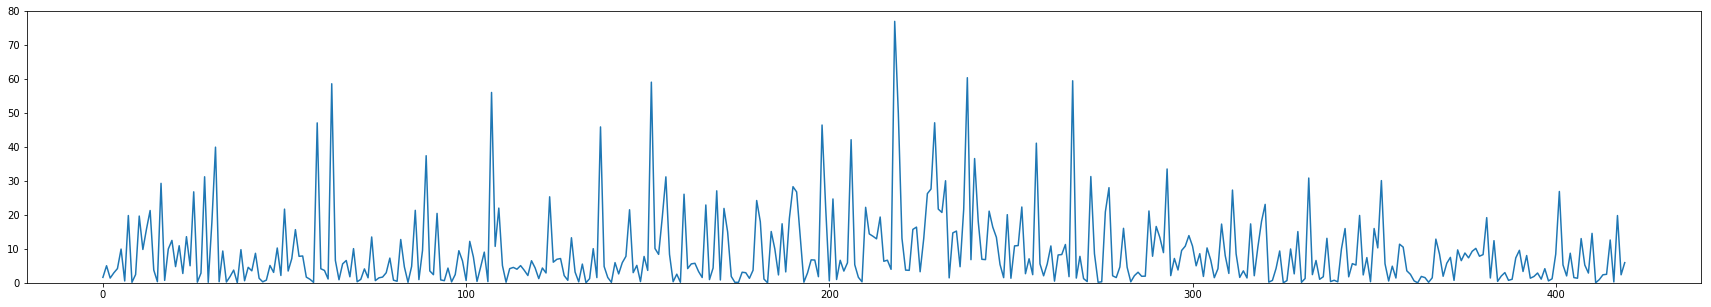

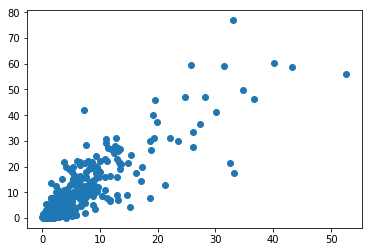

Correlation is:  0.8594997933504274
p-value is:  6.6797288389370854e-124


In [55]:
# result for ~500 files
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 80) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 80) 
plt.show()

plt.scatter(final_result.values(), truth)
plt.show()

# calculate correlation, use Pearson’s Correlation
corr, p = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)
print('p-value is: ',p)

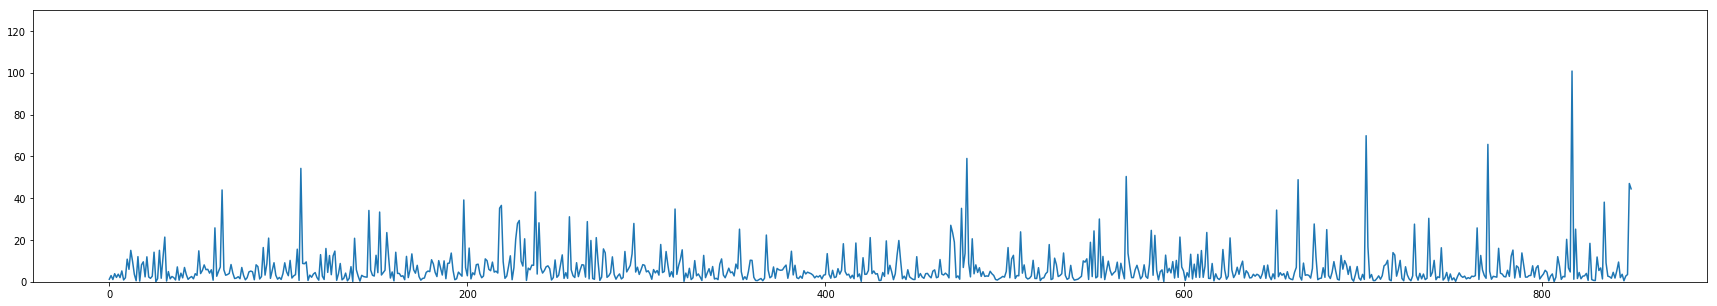

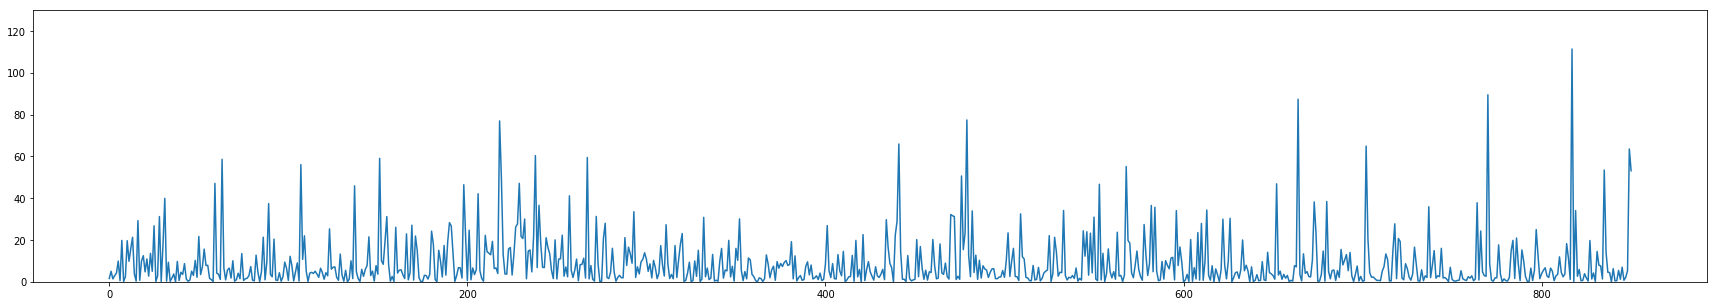

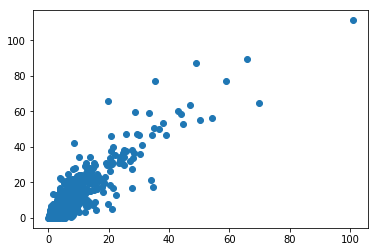

Correlation is:  0.9039123071007312
p-value is:  2.156309136e-315


In [6]:
# result for ~1000 files, with improved algorithm
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 130) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 130) 
plt.show()

plt.scatter(final_result.values(), truth)
plt.show()

# calculate correlation, use Pearson’s Correlation
corr, p = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)
print('p-value is: ',p)

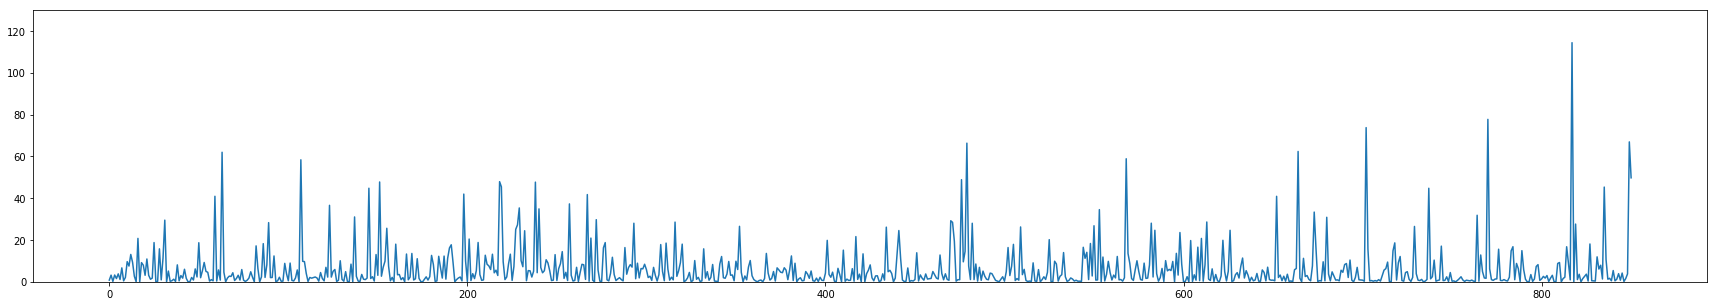

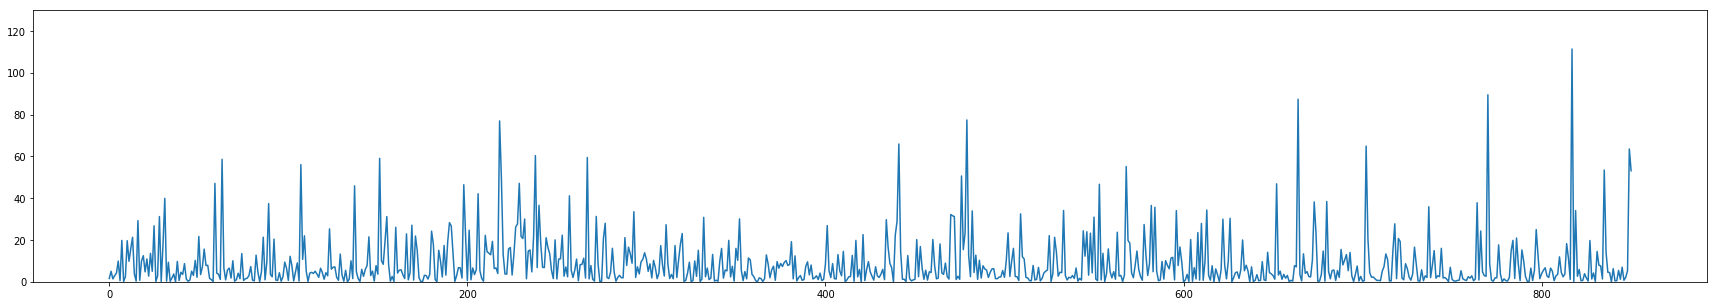

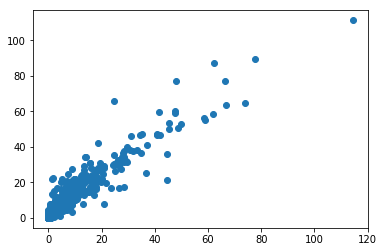

Correlation is:  0.9432858925340283
p-value is:  0.0


In [7]:
# result for ~1000 files, with improved algorithm and updated sleep time
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 130) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 130) 
plt.show()

plt.scatter(final_result.values(), truth)
plt.show()

# calculate correlation, use Pearson’s Correlation
corr, p = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)
print('p-value is: ',p)

In [66]:
# save the result
data = np.asarray(list(final_result.values()))
np.savetxt('predict.txt',data)

In [68]:
# prepare data and label to predict
data = np.asarray(list(final_result.values()))
data = data.reshape(-1,1)
labels = np.asarray(dataToLabel(truth))
labels = labels.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle = True)
y_train = y_train.reshape(-1,)

In [55]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth=200).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
cm = confusion_matrix(y_test, dtree_predictions)
accuracy = np.sum(dtree_predictions.reshape(-1,1) == y_test) / len(y_test)
print(accuracy)
print(cm)

0.7605633802816901
[[94  9  1  0]
 [17 45  3  0]
 [ 2 10 16  2]
 [ 0  0  7  7]]


In [56]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test)
accuracy = gnb.score(X_test, y_test) 
cm = confusion_matrix(y_test, gnb_predictions)
print(accuracy)
print(cm)

0.8215962441314554
[[100   4   0   0]
 [ 14  49   2   0]
 [  3   9  18   0]
 [  0   0   6   8]]


In [58]:
# SVC
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.sum(y_pred.reshape(-1,1) == y_test) / len(y_test)
cm = confusion_matrix(y_test, y_pred)
print(accuracy)
print(cm)

0.8356807511737089
[[100   4   0   0]
 [ 14  49   2   0]
 [  3   9  16   2]
 [  0   0   1  13]]


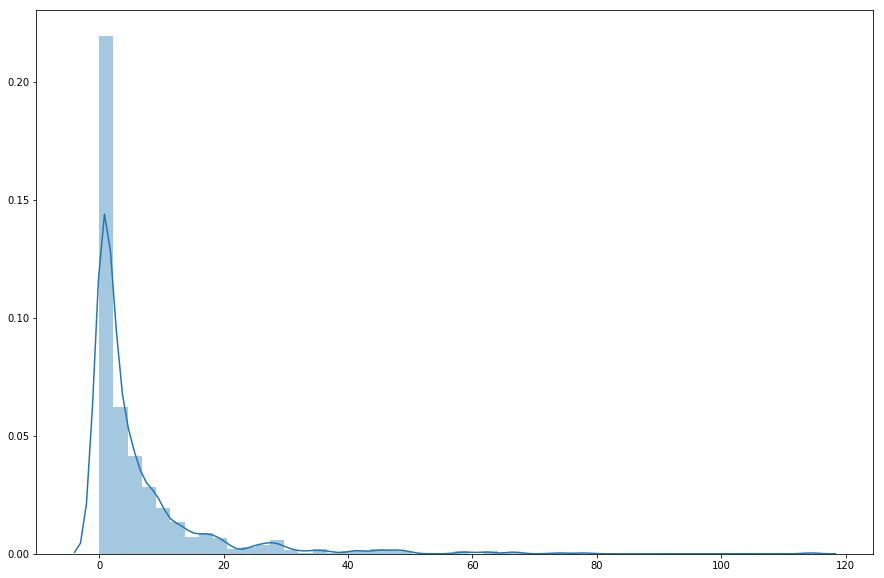

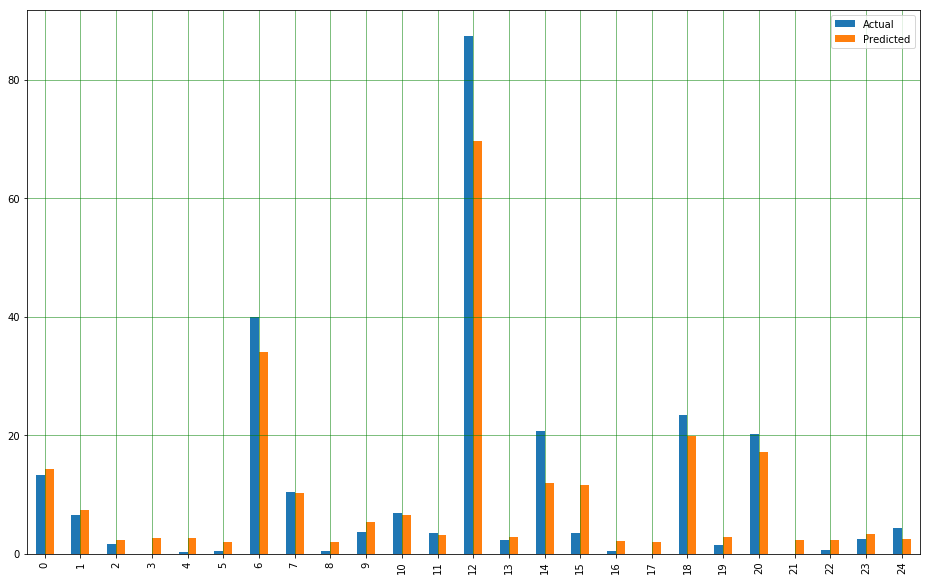

In [72]:
# Linear Regression
data = data.reshape(-1,1)
truth = np.asarray(truth).reshape(-1,1)
plt.figure(figsize = (15, 10))
plt.tight_layout()
seabornInstance.distplot(data)
X_train, X_test, y_train, y_test = train_test_split(data, truth, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color = 'green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

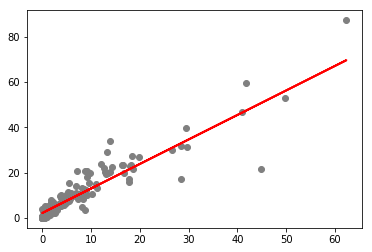

In [73]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [74]:
pred_label = dataToLabel(y_pred)
truth_label = dataToLabel(y_test)
count = 0
for i in range(len(pred_label)):
    if pred_label[i] == truth_label[i]:
        count += 1
accuracy = count / len(truth_label)
cm = confusion_matrix(pred_label, truth_label)
print(accuracy)
print(cm)

0.8654970760233918
[[83  9  0  0]
 [ 4 39  7  0]
 [ 0  0 18  1]
 [ 0  0  2  8]]


In [75]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.6398440563180685
Mean Squared Error: 19.20520565081752
Root Mean Squared Error: 4.3823744306959345
